In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt

# BlackJack simulator



### Planned steps

1. ~~Make the random function work (make sure the arguments inside local functions work properly)~~
2. ~~Basic Strategy engine~~
3. ~~Make the function appened to data frame~~
3. ~~bets - possible outcomes~~
4. analize the change of True count as the shoe progresses - how long can a shoe be 'hot'?
5. ~~simulate whole card counting trips - assume bankroll and how it changes in time~~ 
3. implement "miss engine" - one that every one in a while misses the best move
1. ~~implement exceptions engine - to take into account true count into play. To be made possible with 3 dimensional numpy arrays~~
2. ~~Kelly criterion analysis - optimize the bet size depending on True count and available bankroll~~
3. optimize the function - multithread or GPU-computing


## Defining key functions

* shuffle - prepares a shoe of cards for function 'game_of_blackjack' to play
* game_of_blackjack - simulates a game of BlackJack using basic stretegy as players decision engine
* BJ_simulator - combines multiple games into a series, iterates over 'game_of_blackjack'


In [2]:
from blackjack_main_function import BJ_simulator

## Simulating 640,000 games
* 10000 iterations of shoes, each consisting 8 decks of cards and 8 games for every deck
* 100$ as the standard starting bet

In [3]:
data = BJ_simulator(iterations=10000, decision_engine= 'basic')
data = pd.DataFrame(data)

In [4]:
data.head()

,Starting cards,Dealers card,Hands amount,$result,$account,Running count,True count,Cards left at start,Cards Left after the game
0,"[Heart 9, Diamond A]",Diamond Q,1,100.0,10100.0,0,0.000000,416,410
1,"[Heart 9, Spade Q]",Spade J,1,100.0,10200.0,0,0.000000,410,404
2,"[Spade K, Spade 3]",Diamond K,1,-100.0,10100.0,1,0.128713,404,397
3,"[Heart 9, Spade 4]",Spade Q,1,-100.0,10000.0,2,0.261965,397,392
4,"[Club A, Heart 3]",Club A,1,-100.0,9900.0,1,0.132653,392,381


In [5]:
data.describe()

,Hands amount,$result,$account,Running count,True count,Cards left at start,Cards Left after the game
count,640000.000000,640000.000000,640000.000000,640000.000000,640000.000000,640000.000000,640000.000000
mean,1.029123,-0.032500,-1432.098750,-0.079666,0.005989,238.457455,232.821548
std,0.195361,116.461286,29613.944439,7.709082,2.570033,104.271583,104.275403
min,1.000000,-900.000000,-74450.000000,-41.000000,-21.584906,23.000000,17.000000
25%,1.000000,-100.000000,-21100.000000,-5.000000,-1.151899,148.000000,143.000000
50%,1.000000,0.000000,-2900.000000,0.000000,0.000000,239.000000,233.000000
75%,1.000000,100.000000,19650.000000,5.000000,1.130435,329.000000,323.000000
max,7.000000,800.000000,60200.000000,40.000000,20.347826,416.000000,412.000000


### counting cards basics
A key to counting cards in blackjack is keeping track of Running count (the amount of higher value cards left in the deck above expected) and adjusting it by dividing by the amount of cards left in a shoe. This result is called True count

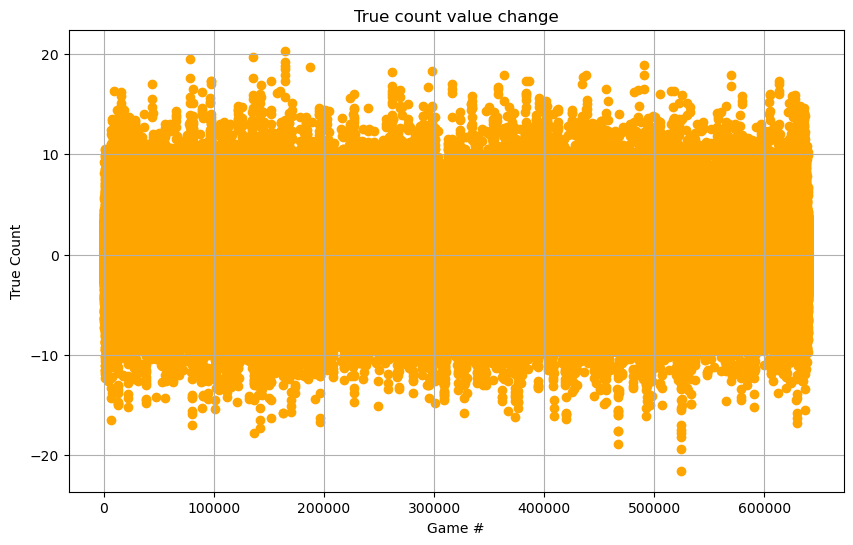

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(data.index, data['True count'], color='orange')
plt.title('True count value change')
plt.xlabel('Game #')
plt.ylabel('True Count')
plt.grid(True)
plt.show()


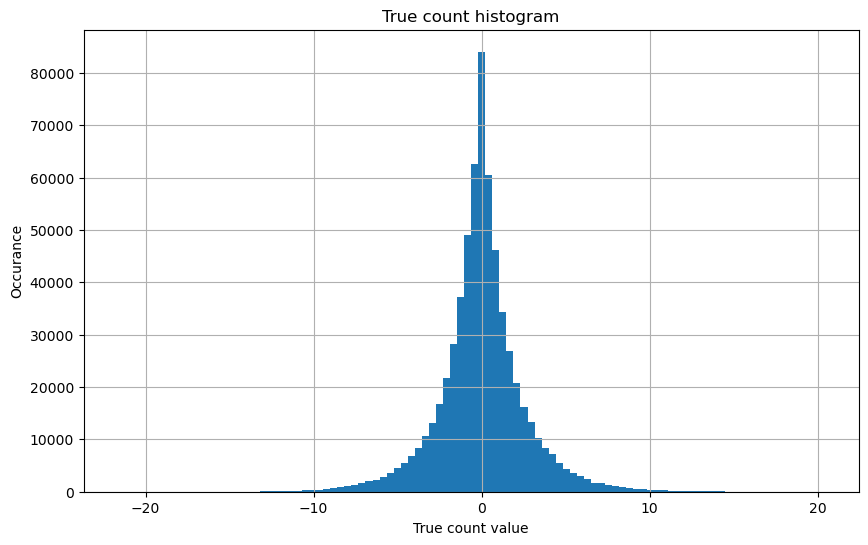

In [7]:
plt.figure(figsize=(10, 6))
data['True count'].hist(bins=100)
plt.title('True count histogram')
plt.xlabel('True count value')
plt.ylabel('Occurance')
plt.show()

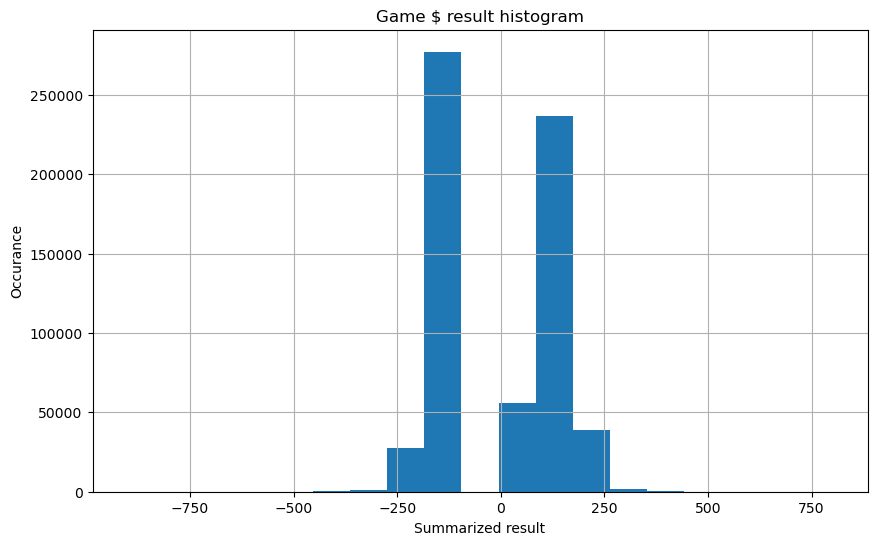

In [8]:
plt.figure(figsize=(10, 6))
data['$result'].hist(bins=19)
plt.title('Game $ result histogram')
plt.xlabel('Summarized result')
plt.ylabel('Occurance')
plt.show()

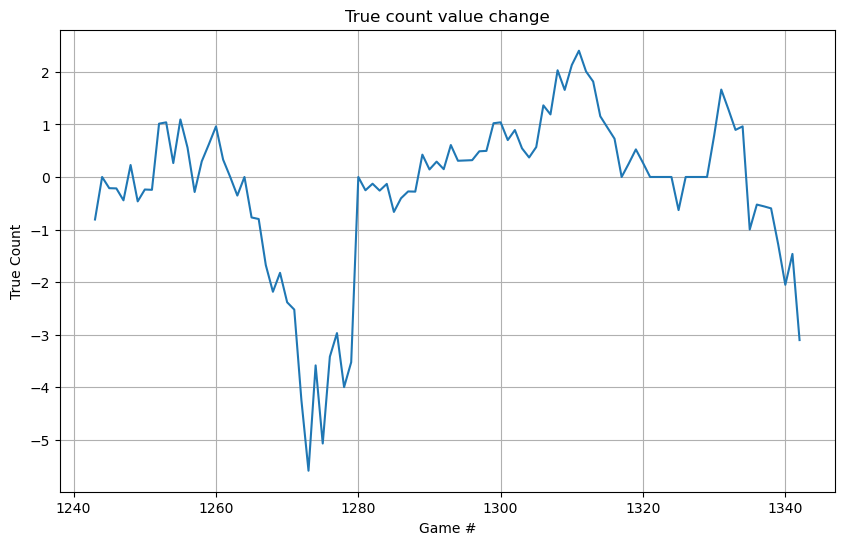

In [9]:
plt.figure(figsize=(10, 6))
r = random.randint(0, 15899)
d = data.iloc[r:(r+100)]
plt.plot(d.index, d['True count'])
plt.title('True count value change')
plt.xlabel('Game #')
plt.ylabel('True Count')
plt.grid(True)
plt.show()


## How good of a predictor is the value of True Count?
In general pretty weak - most books assume 0.5% of edge for the player more for every unit of TC

Lets run a Linear Regression model and Logistic Regression model to find out how strong it the predictiveness of TC

MSE:  13521.215524995301
R^2:  4.5133447819756256e-05


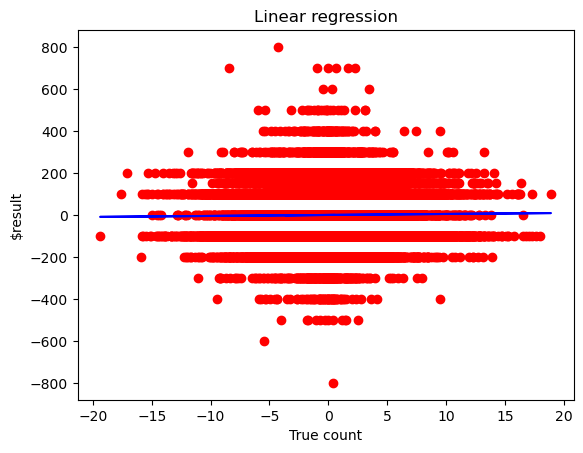

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


X = data[['True count']]
Y = data['$result']


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)



model = LinearRegression()


model.fit(X_train, Y_train)



Y_pred = model.predict(X_test)


mse = mean_squared_error(Y_test, Y_pred)
print("MSE: ", mse)


r2_score = model.score(X_test, Y_test)
print("R^2: ", r2_score)


plt.scatter(X_test, Y_test, color='red')
plt.plot(X_test, Y_pred, color='blue')
plt.title('Linear regression')
plt.xlabel('True count')
plt.ylabel('$result')
plt.show()


Accuracy:  0.5236640625
Confusion matrix: 
 [[   86 60887]
 [   84 66943]]


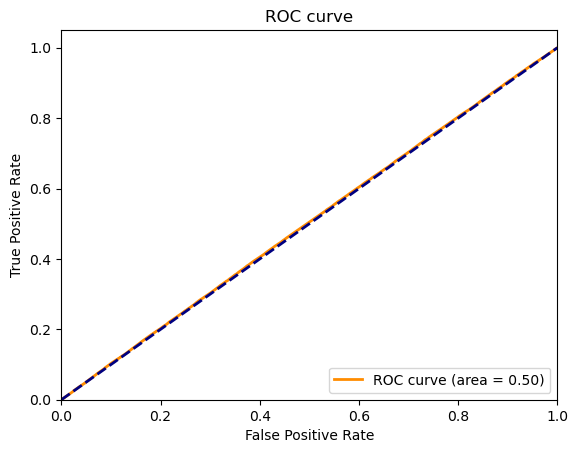

In [11]:
data1= data
data1['win'] = data1['$result'].apply(lambda x: 1 if x >= 0 else 0)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix



X = data1[['True count']]
Y = data1['win']           


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)


model = LogisticRegression()


model.fit(X_train, Y_train)


Y_pred = model.predict(X_test)


accuracy = accuracy_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

print("Accuracy: ", accuracy)
print("Confusion matrix: \n", conf_matrix)

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


Y_pred_proba = model.predict_proba(X_test)[:, 1]


fpr, tpr, thresholds = roc_curve(Y_test, Y_pred_proba)

roc_auc = auc(fpr, tpr)


plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()


# Testing the efectivnes of Kelly Criterion and Strategy Deviations based on True Count values
True Count has 2 important applications - it allows to adjust the bet depending on the probability of win and allows to deviete form Basic Stretegy when it starts to be beneficial to the player

In below scenario we used a simplified Kelly Criterion to choose the optimal bet. It is optimized better than usually card counters do, because it is a descrete number in our example, wheres in most cases players would fix the strategy for each day of counting (not chenging the startegy between hands)

Additionally we use the numpy arrays from game_of_blackjack to deviate from Basic Strategy when it is more optimal for the player

In [20]:
data = BJ_simulator(iterations=10000, decision_engine= 'kelly')
data = pd.DataFrame(data)

In [21]:
data.describe()

,Hands amount,$result,$account,Running count,True count,Cards left at start,Cards Left after the game
count,640000.000000,640000.000000,6.400000e+05,640000.000000,640000.000000,640000.000000,640000.000000
mean,1.029514,20.492284,5.407102e+06,-0.147486,-0.015730,238.398269,232.759100
std,0.196690,3853.746435,5.078760e+06,7.693362,2.552949,104.338089,104.344177
min,1.000000,-60000.000000,-3.809179e+04,-36.000000,-18.270270,30.000000,25.000000
25%,1.000000,-100.000000,1.233547e+05,-5.000000,-1.171831,148.000000,143.000000
50%,1.000000,0.000000,4.345062e+06,0.000000,0.000000,238.000000,233.000000
75%,1.000000,100.000000,1.076596e+07,5.000000,1.097625,329.000000,323.000000
max,7.000000,70000.000000,1.395036e+07,42.000000,28.108108,416.000000,412.000000


# True Count startegy deviations

In [34]:
data = BJ_simulator(iterations=10000, decision_engine = 'kelly_and_exceptions', bankroll=10000, min_table_bet = 100, max_table_bet = 1000)
data = pd.DataFrame(data)
data.describe()

,Hands amount,$result,$account,Running count,True count,Cards left at start,Cards Left after the game
count,639998.000000,639998.000000,639998.000000,639998.000000,639998.000000,639998.000000,639998.000000
mean,1.031803,1.344283,682590.419644,-0.077714,0.003816,238.674579,233.042724
std,0.244319,465.322794,294442.447882,7.628203,2.533004,104.171544,104.180753
min,1.000000,-18000.000000,-16558.238727,-33.000000,-22.285714,7.000000,2.000000
25%,1.000000,-100.000000,469838.652575,-5.000000,-1.130435,149.000000,143.000000
50%,1.000000,0.000000,833238.652575,0.000000,0.000000,239.000000,233.000000
75%,1.000000,100.000000,894288.652575,5.000000,1.124324,329.000000,323.000000
max,28.000000,23000.000000,991138.652575,36.000000,24.470588,416.000000,412.000000


In [30]:
data[data['$result']>5000]

,Starting cards,Dealers card,Hands amount,$result,$account,Running count,True count,Cards left at start,Cards Left after the game


In [31]:
data['$result'].sum()

-157027.3325703696

# Simulation wrapper

Now let's implement a simulation wrapper, so that the real EV could be simulated

In [3]:
from simulation_wrapper import BJ_simulation_wrapper

In [36]:
metadata, df = BJ_simulation_wrapper(
        trips = 20,
        starting_bankroll = 10000,
        min_table_bet=10,
        games_per_trip=1000,
        max_table_bet= 500,
        shoe_size=8,
        games_per_deck=8,
        decision_engine='kelly_and_exceptions')
metadata

,series id,$account,trip $ result,ruin game,average hand value,series length,ruin,starting bankroll
0,0,740.947996,-9259.052004,11071.0,-9.259052,64000,1,10000
1,1,115670.954064,105670.954064,NaN,105.670954,64000,0,10000
2,2,-1418.739261,-11418.739261,5899.0,-11.418739,64000,1,10000
3,3,2337.986031,-7662.013969,NaN,-7.662014,64000,0,10000
4,4,111643.170958,101643.170958,NaN,101.643171,64000,0,10000
5,5,59685.285558,49685.285558,NaN,49.685286,64000,0,10000
6,6,72279.096784,62279.096784,NaN,62.279097,64000,0,10000
7,7,8198.974862,-1801.025138,NaN,-1.801025,64000,0,10000
8,8,-614.298625,-10614.298625,25899.0,-10.614299,64000,1,10000
9,9,101785.460487,91785.460487,NaN,91.785460,64000,0,10000


In [40]:
metadata.describe()

,series id,$account,trip $ result,ruin game,average hand value,series length,ruin,starting bankroll
count,20.00000,20.000000,20.000000,8.000000,20.000000,20.0,20.000000,20.0
mean,9.50000,45694.940200,35694.940200,13039.500000,35.694940,64000.0,0.400000,10000.0
std,5.91608,48692.680139,48692.680139,9421.914501,48.692680,0.0,0.502625,0.0
min,0.00000,-5422.208657,-15422.208657,1064.000000,-15.422209,64000.0,0.000000,10000.0
25%,4.75000,78.084149,-9921.915851,5313.750000,-9.921916,64000.0,0.000000,10000.0
50%,9.50000,32968.252488,22968.252488,13123.500000,22.968252,64000.0,0.000000,10000.0
75%,14.25000,88627.813385,78627.813385,18530.750000,78.627813,64000.0,1.000000,10000.0
max,19.00000,117065.710504,107065.710504,25899.000000,107.065711,64000.0,1.000000,10000.0


In [41]:
df

,Starting cards,Dealers card,Hands amount,$result,$account,Running count,True count,Cards left at start,Cards Left after the game,series id,game number,ruin,ruin game
0,"[Spade A, Club 4]",Spade 2,1,-10.0,9990.000000,0,0.000000,416,409,0,1,False,NaN
1,"[Spade 6, Diamond Q]",Club 10,1,-10.0,9980.000000,2,0.254279,409,405,0,2,False,NaN
2,"[Club 9, Heart 2]",Heart A,1,-10.0,9970.000000,0,0.000000,405,401,0,3,False,NaN
3,"[Spade 2, Heart 10]",Spade Q,1,10.0,9980.000000,-1,-0.129676,401,394,0,4,False,NaN
4,"[Diamond 4, Heart K]",Diamond 10,1,0.0,9980.000000,-2,-0.263959,394,389,0,5,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279973,"[Diamond 4, Diamond 3]",Diamond 10,1,10.0,278.878407,-5,-2.795699,93,87,19,63983,False,NaN
1279974,"[Heart 9, Heart 2]",Spade 2,1,20.0,298.878407,-5,-2.988506,87,80,19,63984,False,NaN
1279975,"[Spade 6, Club 2]",Diamond 5,1,10.0,308.878407,-5,-3.250000,80,74,19,63985,False,NaN
1279976,"[Diamond 2, Club Q]",Diamond 7,2,-20.0,288.878407,-4,-2.810811,74,62,19,63986,False,NaN


In [42]:
df.describe()

,Hands amount,$result,$account,Running count,True count,Cards left at start,Cards Left after the game,series id,game number,ruin game
count,1.279978e+06,1.279978e+06,1.279978e+06,1.279978e+06,1.279978e+06,1.279978e+06,1.279978e+06,1.279978e+06,1.279978e+06,277928.000000
mean,1.031946e+00,5.577430e-01,2.738119e+04,-1.391500e-01,-5.831717e-03,2.386294e+02,2.329975e+02,9.499870e+00,3.199995e+04,37903.317759
std,2.441361e-01,1.690236e+02,3.156221e+04,7.660007e+00,2.538364e+00,1.041797e+02,1.041864e+02,5.766225e+00,1.847490e+04,16603.696643
min,1.000000e+00,-1.032679e+04,-6.452209e+03,-3.700000e+01,-2.166667e+01,7.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1064.000000
25%,1.000000e+00,-1.000000e+01,2.988784e+02,-5.000000e+00,-1.159236e+00,1.490000e+02,1.430000e+02,4.000000e+00,1.600000e+04,24073.750000
50%,1.000000e+00,0.000000e+00,1.718450e+04,0.000000e+00,0.000000e+00,2.390000e+02,2.330000e+02,9.000000e+00,3.200000e+04,39930.000000
75%,1.000000e+00,1.000000e+01,4.558239e+04,5.000000e+00,1.115880e+00,3.290000e+02,3.230000e+02,1.400000e+01,4.800000e+04,51861.000000
max,4.300000e+01,1.250000e+04,1.287460e+05,3.600000e+01,2.765957e+01,4.160000e+02,4.120000e+02,1.900000e+01,6.400000e+04,64000.000000


## Multiprocessing - results of simulating 100 trips, 2000 shoes each

In [3]:
metadata = pd.read_csv('meta results.csv')
metadata

,series id,final bankroll,trip $ result,total games played,ruin game,average hand value,ruin,starting bankroll
0,0,109439.463554,89439.463554,128000,41347.0,0.698746,1,20000
1,1,196712.330691,176712.330691,128000,NaN,1.380565,0,20000
2,2,-2685.991816,-22685.991816,128000,32354.0,-0.177234,1,20000
3,3,212898.819488,192898.819488,127997,NaN,1.507057,0,20000
4,4,135069.013588,115069.013588,128000,NaN,0.898977,0,20000
...,...,...,...,...,...,...,...,...
95,95,74474.164527,54474.164527,127999,NaN,0.425583,0,20000
96,96,1905.489020,-18094.510980,128000,17087.0,-0.141363,1,20000
97,97,71912.114357,51912.114357,128000,NaN,0.405563,0,20000
98,98,-4862.610476,-24862.610476,127997,35871.0,-0.194244,1,20000


In [4]:
metadata.describe()

,series id,final bankroll,trip $ result,total games played,ruin game,average hand value,ruin,starting bankroll
count,100.000000,100.000000,100.000000,100.000000,31.000000,100.000000,100.000000,100.0
mean,49.500000,126959.196513,106959.196513,127999.020000,44230.709677,0.835625,0.310000,20000.0
std,29.011492,103608.180886,103608.180886,1.969361,30391.432915,0.809445,0.464823,0.0
min,0.000000,-8642.298381,-28642.298381,127989.000000,9243.000000,-0.223768,0.000000,20000.0
25%,24.750000,-138.983737,-20138.983737,127999.000000,29494.500000,-0.157340,0.000000,20000.0
50%,49.500000,132824.425453,112824.425453,128000.000000,37459.000000,0.881441,0.000000,20000.0
75%,74.250000,212915.737649,192915.737649,128000.000000,47025.500000,1.507181,1.000000,20000.0
max,99.000000,351384.688084,331384.688084,128000.000000,122634.000000,2.588963,1.000000,20000.0


In [5]:
df = pd.read_csv('sim results.csv')
df

,Starting cards,Dealers card,Hands amount,$result,$account,Running count,True count,Cards left at start,Cards Left after the game,series id,game number,ruin,ruin game
0,"['Club 10', 'Diamond 2']",Club 6,1,-10.0,19990.000000,0,0.000000,416,412,0,1,False,NaN
1,"['Diamond 5', 'Club 7']",Heart J,1,-10.0,19980.000000,0,0.000000,412,405,0,2,False,NaN
2,"['Heart 9', 'Spade A']",Spade 9,1,10.0,19990.000000,-1,-0.128395,405,401,0,3,False,NaN
3,"['Diamond 5', 'Heart 10']",Club J,1,-10.0,19980.000000,-2,-0.259352,401,396,0,4,False,NaN
4,"['Club K', 'Spade 6']",Club 8,1,-10.0,19970.000000,-4,-0.525253,396,390,0,5,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12799897,"['Club 5', 'Heart J']",Club 2,1,-10.0,280647.441101,-9,-5.142857,91,85,99,127995,False,NaN
12799898,"['Club 8', 'Club 9']",Spade 6,1,-10.0,280637.441101,-7,-4.282353,85,80,99,127996,False,NaN
12799899,"['Diamond 5', 'Club 3']",Diamond 8,1,10.0,280647.441101,-6,-3.900000,80,73,99,127997,False,NaN
12799900,"['Diamond 10', 'Heart 4']",Heart 2,1,10.0,280657.441101,-1,-0.712329,73,68,99,127998,False,NaN


In [6]:
df.describe()

,Hands amount,$result,$account,Running count,True count,Cards left at start,Cards Left after the game,series id,game number,ruin game
count,1.279990e+07,1.279990e+07,1.279990e+07,1.279990e+07,1.279990e+07,1.279990e+07,1.279990e+07,1.279990e+07,1.279990e+07,1.922448e+06
mean,1.032263e+00,8.356251e-01,7.546173e+04,-1.054917e-01,5.849314e-03,2.385857e+02,2.329518e+02,4.950004e+01,6.400001e+04,8.448666e+04
std,2.450409e-01,2.000136e+02,7.433860e+04,7.652970e+00,2.543685e+00,1.042119e+02,1.042198e+02,2.886608e+01,3.695014e+04,2.803065e+04
min,1.000000e+00,-1.400000e+04,-9.647298e+03,-4.400000e+01,-3.466667e+01,4.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,9.243000e+03
25%,1.000000e+00,-1.000000e+01,9.854007e+03,-5.000000e+00,-1.149171e+00,1.490000e+02,1.430000e+02,2.400000e+01,3.200000e+04,6.335300e+04
50%,1.000000e+00,0.000000e+00,5.596622e+04,0.000000e+00,0.000000e+00,2.390000e+02,2.330000e+02,5.000000e+01,6.400000e+04,8.727300e+04
75%,1.000000e+00,1.000000e+01,1.216774e+05,5.000000e+00,1.118280e+00,3.290000e+02,3.230000e+02,7.500000e+01,9.600000e+04,1.080830e+05
max,4.500000e+01,1.650000e+04,3.648747e+05,4.400000e+01,4.160000e+01,4.160000e+02,4.120000e+02,9.900000e+01,1.280000e+05,1.280000e+05
